> 시작하기 전에

아래 참고자료를 활용하였습니다.

- [Standard Scaler 사용법 at Tensorflow](https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=demian7607&logNo=222009975984)
- [스케일링 관련 유의점](https://for-my-wealthy-life.tistory.com/18)

## 데이터 업로드

Google Colab에서는 런타임 종료 시 파일이 삭제되므로, 매번 업로드하도록 구성하였다.

In [11]:
from google.colab import files

print("car_evaluation.csv 파일을 업로드해주세요.")
uploaded = files.upload()

for fn in uploaded.keys():
  print("Uploaded File '{name}'".format(name = fn))

car_evaluation.csv 파일을 업로드해주세요.


Saving car_evaluation.csv to car_evaluation.csv
Uploaded File 'car_evaluation.csv'


## 업로드한 데이터 확인

In [12]:
!head car_evaluation.csv

vhigh,vhigh,2,2,small,low,unacc
vhigh,vhigh,2,2,small,med,unacc
vhigh,vhigh,2,2,small,high,unacc
vhigh,vhigh,2,2,med,low,unacc
vhigh,vhigh,2,2,med,med,unacc
vhigh,vhigh,2,2,med,high,unacc
vhigh,vhigh,2,2,big,low,unacc
vhigh,vhigh,2,2,big,med,unacc
vhigh,vhigh,2,2,big,high,unacc
vhigh,vhigh,2,4,small,low,unacc


## 데이터 전처리

- `pandas` 라이브러리를 이용하여 CSV 파일을 읽고, LabelEncoder로 범주형 데이터를 숫자 형태의 데이터로 변환한다.
- 나눈 데이터를 StandardScaler로 정규화. **단, 테스트 데이터셋에 대해서는 `fit` 계열 수행하지 말 것!**

> Review 해주신 내용을 반영하여 `data.apply` 기능을 활용, 연산 최적화를 진행하였습니다.

In [71]:
import io
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# 파일 읽기 및 Label Encoder로 데이터 변환
data = pd.read_csv(io.StringIO(uploaded['car_evaluation.csv'].decode('utf-8')))

le = LabelEncoder()
data = data.apply(le.fit_transform)

# 데이터 준비. 마지막 열을 레이블로 지정
x_train, x_test, y_train, y_test = train_test_split(data.iloc[:, :-1], data.iloc[:, -1], test_size=0.2, random_state=42)

# 각각 나눈 데이터를 정규화
ss = StandardScaler()
x_train = ss.fit_transform(x_train)
x_test = ss.transform(x_test)

## PCA 적용 및 시각화

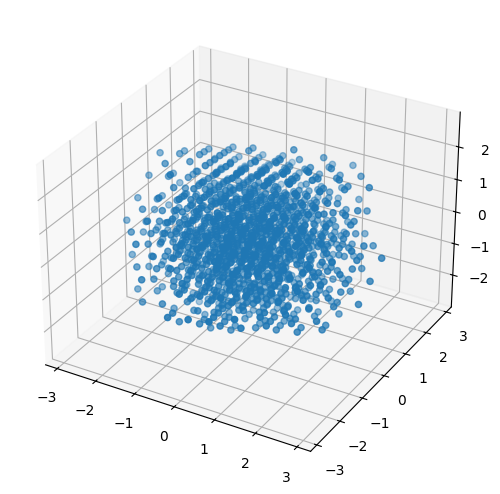

In [78]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca_x_train = pca.fit_transform(x_train)
pca_x_test = pca.transform(x_test)

df = pd.DataFrame(pca_x_train, columns=['2', '1', '2'])
fig = plt.figure(constrained_layout=True)
ax = fig.add_subplot(projection="3d")
ax.scatter(df.iloc[:,0],df.iloc[:, 1], df.iloc[:, 2])
plt.show()

## 모델 학습

### Random Forest

In [79]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier(random_state=42)
rf.fit(x_train, y_train)
rf_res = rf.predict(x_test)

rf_score = accuracy_score(y_test, rf_res)

pca_rf = RandomForestClassifier(random_state=42)
pca_rf.fit(pca_x_train, y_train)
pca_rf_res = pca_rf.predict(pca_x_test)

pca_rf_score = accuracy_score(y_test, pca_rf_res)



## 결과 시각화

- **PCA 축소 결과 시각화**: 2D/3D 산점도를 통해 데이터 분포를 시각화
- **모델 성능 비교**: PCA 적용 전후의 랜덤포레스트 모델 정확도를 막대그래프로 시각화
- **주성분 기여도 분석**: 각 주성분이 데이터 분산에 기여한 비율(Explained Variance Ratio)을 막대그래프로 시각화

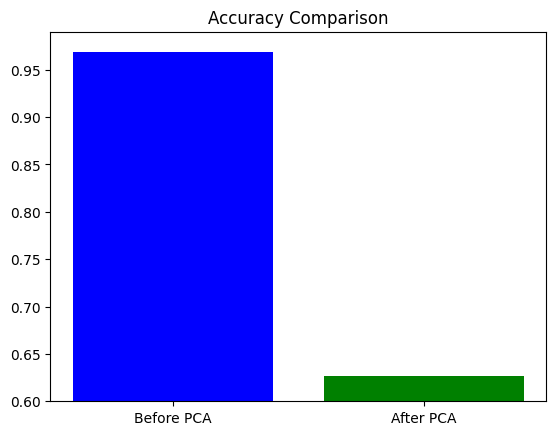

0.9682080924855492 0.6271676300578035


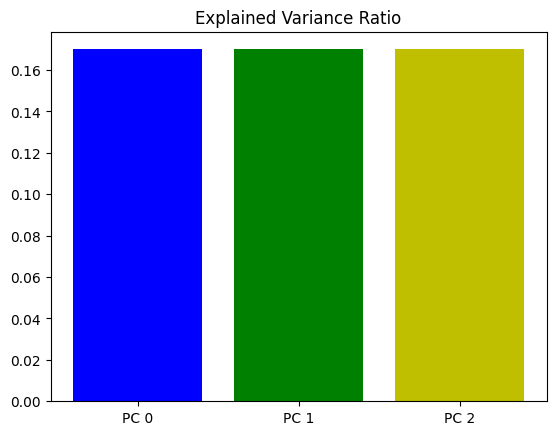

In [80]:
import matplotlib.pyplot as plt

# 모델 성능 비교

plt.bar(np.arange(2), [rf_score, pca_rf_score], color=['b', 'g'])
plt.ylim(0.6, 0.99)
plt.xticks(np.arange(2), ['Before PCA', 'After PCA'])
plt.title("Accuracy Comparison")
plt.show()

print(rf_score, pca_rf_score)

# 주성분 기여도 분석
plt.bar(["PC %d" % i for i in np.arange(len(pca.explained_variance_ratio_))], pca.explained_variance_ratio_.round(2), color=['b', 'g', 'y'])
plt.title("Explained Variance Ratio")
plt.show()

우선 아예 실행되지 않는 문제는 해결하였으나,
PCA 방식에서 심각한 성능 하락(2차원, 3차원 불문)이 보여 변환 과정에서 문제가 있었으리라 유추된다.

관련하여 시도하였던 방식은 다음과 같다.

- StandardScaler를 데이터 전체에 적용: PCA 변환까지는 이뤄졌으나, 모델 학습 불가 (Classifier를 학습시키려고 하는 것 같다며 오류 발생)
- y_train, y_test에 정규화, PCA 등 적용: 데이터 규격 문제로 비호환
- PCA `fit_transform` 진행 시 `y_train` 함께 넣어주기: 변화 없음